In [1]:
pip install --upgrade fosforml

Requirement already up-to-date: fosforml in /opt/conda/lib/python3.9/site-packages (1.1.8)
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import fosforml
from fosforml.model_manager.snowflakesession import get_session
my_session = get_session()

In [4]:
my_session.connection.database

'ASSORTMENT_PLANNING'

In [5]:
my_session.connection.schema

'CPG_BRONZE'

In [6]:
table_name = "ASSORTMENT_PLANNING.CPG_BRONZE.SALES_CLEAN"

In [7]:
sf_df = my_session.sql("select * from {}".format(table_name))

In [8]:
type(sf_df)

snowflake.snowpark.dataframe.DataFrame

In [9]:
df=sf_df.to_pandas()

In [10]:
type(df)

pandas.core.frame.DataFrame

In [11]:
df=df.sort_values(by='TRANS_DATE')

In [12]:
df.head(5)

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE,DISTRIBUTOR_CODE,OUTLET_CODE,CITY,STATE,COUNTY,STREET,PRODUCT_CODE,CATEGORY,SUBCATEGORY,BRAND
780456,202309,2023-08-29,2023-08-28,172.73,1,0.000375,172.727273,202209,DB0209,OL175129,Truth or Consequences,New Mexico,City Center,Str3,PRD0059,Perfume and Deodrants,Male Deodrant,Sapphire
800539,202309,2023-08-29,2023-08-28,142.86,16,0.000384,142.857143,202209,DB0655,OL144514,West Point,Mississippi,Silver,Str2,PRD0106,Hair Care,Shampoo,Hair & Shoulders
800538,202309,2023-08-29,2023-08-28,405.64,4,0.000428,418.181818,202209,DB0110,OL96826,Overland Park,Kansas,City Center,Str5,PRD0065,Hair Care,Hair Oil,Crimson
800537,202309,2023-08-29,2023-08-28,407.14,48,0.000816,428.571429,202209,DB0209,OL128819,Columbus,Georgia,Silver,Str2,PRD0028,Soap,Toilet Soap,Indigo
800536,202309,2023-08-29,2023-08-28,345.45,2,0.000500,345.454545,202209,DB0706,OL12592,Nashville,Indiana,City Center,Str4,PRD0122,Perfume and Deodrants,Female Deodrant,Lilac


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 966400 entries, 780456 to 883818
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   MNTH_CODE         966400 non-null  int32  
 1   TRANS_DATE        966400 non-null  object 
 2   START_DATE        966400 non-null  object 
 3   SALES_VALUE       966400 non-null  float64
 4   SALES_UNITS       966400 non-null  int16  
 5   SALES_VOLUME      966400 non-null  float64
 6   SALES_PTR_VALUE   966400 non-null  float64
 7   OC_CODE           966400 non-null  int32  
 8   DISTRIBUTOR_CODE  966400 non-null  object 
 9   OUTLET_CODE       966400 non-null  object 
 10  CITY              966400 non-null  object 
 11  STATE             966400 non-null  object 
 12  COUNTY            966400 non-null  object 
 13  STREET            966400 non-null  object 
 14  PRODUCT_CODE      966400 non-null  object 
 15  CATEGORY          966400 non-null  object 
 16  SUBCATEGORY       96

In [14]:
#Converting into datetime format

df['TRANS_DATE'] = pd.to_datetime(df['TRANS_DATE'])
df['START_DATE'] = pd.to_datetime(df['START_DATE'])

In [15]:
df.shape

(966400, 18)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 966400 entries, 780456 to 883818
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   MNTH_CODE         966400 non-null  int32         
 1   TRANS_DATE        966400 non-null  datetime64[ns]
 2   START_DATE        966400 non-null  datetime64[ns]
 3   SALES_VALUE       966400 non-null  float64       
 4   SALES_UNITS       966400 non-null  int16         
 5   SALES_VOLUME      966400 non-null  float64       
 6   SALES_PTR_VALUE   966400 non-null  float64       
 7   OC_CODE           966400 non-null  int32         
 8   DISTRIBUTOR_CODE  966400 non-null  object        
 9   OUTLET_CODE       966400 non-null  object        
 10  CITY              966400 non-null  object        
 11  STATE             966400 non-null  object        
 12  COUNTY            966400 non-null  object        
 13  STREET            966400 non-null  object        
 14  PROD

Clustering the Objects

In [17]:
import pandas as pd

# Group by OUTLET_CODE and aggregate
aggregated_df = df.groupby('OUTLET_CODE').agg(
    total_sales_value=('SALES_VALUE', 'sum'),
    total_sales_units=('SALES_UNITS', 'sum'),
    total_transactions=('TRANS_DATE', 'count'),
    unique_transactions=('TRANS_DATE', 'nunique'),
    unique_products=('PRODUCT_CODE', 'nunique')
).reset_index()

# Calculate average order value
aggregated_df['avg_order_value'] = aggregated_df['total_sales_value'] / aggregated_df['unique_transactions']

# Group by OUTLET_CODE and CATEGORY to get total sales units for each category by outlet
category_sales_df = df.groupby(['OUTLET_CODE', 'CATEGORY']).agg(
    category_sales_units=('SALES_UNITS', 'sum')
).reset_index()

# Pivot the category sales data to create separate columns for each category
category_sales_pivot = category_sales_df.pivot(index='OUTLET_CODE', columns='CATEGORY', values='category_sales_units').fillna(0)

# Merge the pivoted data with the aggregated data
merged_df = pd.merge(aggregated_df, category_sales_pivot, on='OUTLET_CODE')

# Calculate the ratio of category sales units to total sales units by outlet
for category in category_sales_pivot.columns:
    merged_df[f'{category}_sales_ratio'] = merged_df[category] / merged_df['total_sales_units']

print(merged_df)

      OUTLET_CODE  total_sales_value  total_sales_units  total_transactions  \
0         OL10328            4904.27                221                  34   
1         OL10329           42893.83               1148                 195   
2         OL10330          324169.05               3124                 573   
3         OL10331           12422.54                 87                  49   
4         OL10332           36331.30               4204                 147   
...           ...                ...                ...                 ...   
18828     OL97620           52546.41               1340                 183   
18829     OL97621           20248.25                839                  76   
18830     OL97622            1803.26                184                  15   
18831     OL97623            3100.27                448                  29   
18832     OL97624             976.40                160                  12   

       unique_transactions  unique_products  avg_or

In [18]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18833 entries, 0 to 18832
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   OUTLET_CODE                        18833 non-null  object 
 1   total_sales_value                  18833 non-null  float64
 2   total_sales_units                  18833 non-null  int64  
 3   total_transactions                 18833 non-null  int64  
 4   unique_transactions                18833 non-null  int64  
 5   unique_products                    18833 non-null  int64  
 6   avg_order_value                    18833 non-null  float64
 7   Dental                             18833 non-null  float64
 8   Hair Care                          18833 non-null  float64
 9   Kids Care                          18833 non-null  float64
 10  Lotion                             18833 non-null  float64
 11  Perfume and Deodrants              18833 non-null  flo

In [20]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming merged_df is your DataFrame with the required features
# Select the features for clustering
features = [ 
    'unique_products', 'avg_order_value', 'total_sales_value', 'total_sales_units', 'total_transactions',
    'Dental_sales_ratio', 'Hair Care_sales_ratio', 'Kids Care_sales_ratio', 
    'Lotion_sales_ratio', 'Perfume and Deodrants_sales_ratio', 
    'Soap_sales_ratio', 'Wipes_sales_ratio'
]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_df[features])

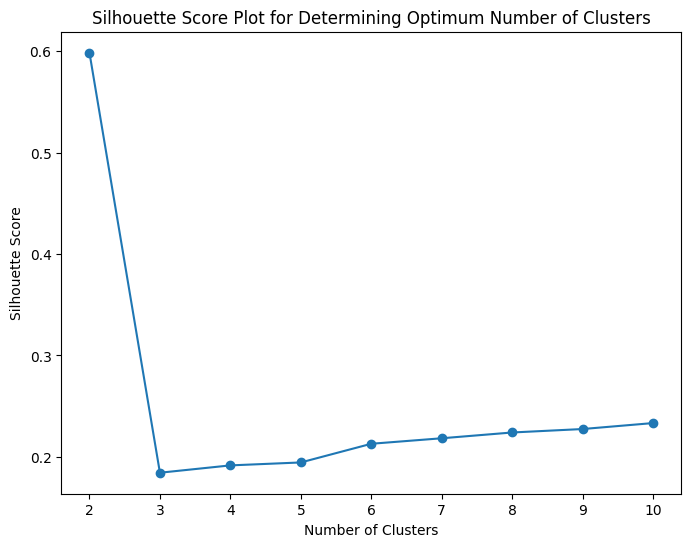

In [22]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Plot for Determining Optimum Number of Clusters')
plt.show()

In [23]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)  # You can choose the number of clusters (n_clusters) as needed
merged_df['cluster'] = kmeans.fit_predict(scaled_features)

print(merged_df)

      OUTLET_CODE  total_sales_value  total_sales_units  total_transactions  \
0         OL10328            4904.27                221                  34   
1         OL10329           42893.83               1148                 195   
2         OL10330          324169.05               3124                 573   
3         OL10331           12422.54                 87                  49   
4         OL10332           36331.30               4204                 147   
...           ...                ...                ...                 ...   
18828     OL97620           52546.41               1340                 183   
18829     OL97621           20248.25                839                  76   
18830     OL97622            1803.26                184                  15   
18831     OL97623            3100.27                448                  29   
18832     OL97624             976.40                160                  12   

       unique_transactions  unique_products  avg_or

In [24]:
# Count the number of OUTLET_CODEs by cluster
outlet_counts_by_cluster = merged_df.groupby('cluster')['OUTLET_CODE'].nunique()

# Display the counts
print(outlet_counts_by_cluster)

cluster
0    17869
1      964
Name: OUTLET_CODE, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example visualization Clusters of x VS y
sns.scatterplot(x='unique_products', y='FREQUENCY', hue='CLUSTER', data=merged_df)
plt.title('Clusters of OUTLET_CODE')
plt.show()

In [ ]:
merged_df.to_csv('merged_data.csv', index=False)